## Directory Structure
PLEASE make sure your directory looks like this:
- root_dir
    - pixel-nerf (clone/pull from github)
    - adaptive-volume-rendering (clone/pull from github)
        - 6S980_Project.ipynb
    - scene-representation-networks (clone/pull from github)
    - data
    - checkpoints
    - ......
    
Then set your pwd to root_dir

## Relevant Repos

- PixelNeRF repo: https://github.com/sxyu/pixel-nerf

- SRN repo: https://github.com/vsitzmann/scene-representation-networks

- SRN raymarcher algorithm: https://github.com/vsitzmann/scene-representation-networks/blob/master/custom_layers.py

## Data

- Currently using cars dataset from SRN

## What we did

- Yanke: Debug is finished.
- Yanke: Now can take in view directions as inputs


## TODO
- Need to incorporate input ray directions.
- Now normal renderer is just simple evenly sample. Need to add importance weighting later.

In [1]:
root_dir = "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"       # This is the only thing you need to change.
%cd "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"

# root_dir = "/Users/jameszli/desktop/MIT/6.S980/"       # This is the only thing you need to change.
# %cd "/Users/jameszli/desktop/MIT/6.S980/"

/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project


In [2]:
# Install everything
%pip install -r adaptive-volume-rendering/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import everything
import sys

sys.path.insert(0, f"{root_dir}/scene-representation-networks/")
sys.path.insert(0, f"{root_dir}/pixel-nerf/src/")
sys.path.insert(0, f"{root_dir}/adaptive-volume-rendering/")

from dataset import *
from models import *
from renderers import *
from trains import *
from utils import *
from model import make_model, loss

print(f"Installed Torch version: {torch.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Installed Torch version: 1.13.0
cpu


## Setup & Load Test Data

In [4]:
# Download data and weights

# Make a new directory
!mkdir data
!mkdir checkpoints

# Download Test Dataset
if not os.path.exists(f"{root_dir}data/cars_train.hdf5"):
    # Download SRNs-cars dataset
    gdown.download("https://drive.google.com/uc?id={}".format("1SBjlsizq0sFNkCZxMQh-pNRi0HyFozKb"),f"{root_dir}data/cars_train.hdf5")

# View test image
# sl = 64
# dataset = SRNsCars(root_dir,img_sidelength=sl)
# mi, rgb = next(iter(dataset))

# rgb = rgb.reshape(sl, sl, 3).view()

# plt.imshow(rgb)
# plt.show()

# print("Cam2world ", mi['cam2world'])
# print("Intrinsics ", mi['intrinsics'])
# print("Pixel coords shape", mi['x_pix'].shape, mi['x_pix'].max())
# print("Scene idx", mi['idx'])

## Download pretrained weights from PixelNeRF
if not os.path.exists(f"{root_dir}checkpoints/pixel_nerf_weights.zip"):
  gdown.download("https://drive.google.com/uc?id={}".format("1UO_rL201guN6euoWkCOn-XpqR2e8o6ju"),f"{root_dir}checkpoints/pixel_nerf_weights.zip")
  !unzip checkpoints/pixel_nerf_weights.zip -d checkpoints/

mkdir: data: File exists
mkdir: checkpoints: File exists


## Renderer

Loading PixlNeRF models

- The volume renderer is in src/nerf.py
- Can easily wrap a net with a renderer using _RenderWrapper function
- The current volume renderer samples points in the following way:
  - Sample 64 coarse points (uniform sample)
  - Sample 16 fine points (importance sample, still need to check how)
  - Compute an expected depth, then sample 16 random normal points with sd=0.01 around that depth.

In [5]:
# Create a custom conf
from pyhocon import ConfigFactory
conf = ConfigFactory.parse_file(f"adaptive-volume-rendering/conf/default_mv.conf")

# Create a pixelnerf net
net = make_new_model(conf["model"]).to(device=device)
net.stop_encoder_grad = True

# Combine with volumerenderer
renderer = VolumeRenderer.from_conf(conf["normal_renderer"]).to(
    device=device
)

rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)

Using torchvision resnet34 encoder


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step 0: loss = 0.32393


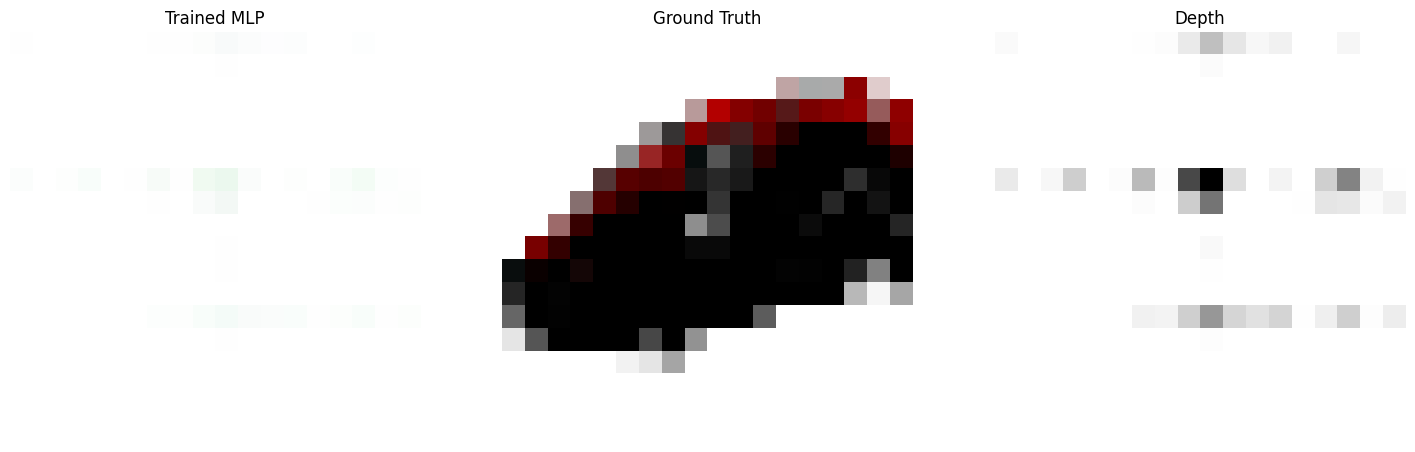

1
2
3
4
5
6
7
8
9
10
Step 10: loss = 0.22713


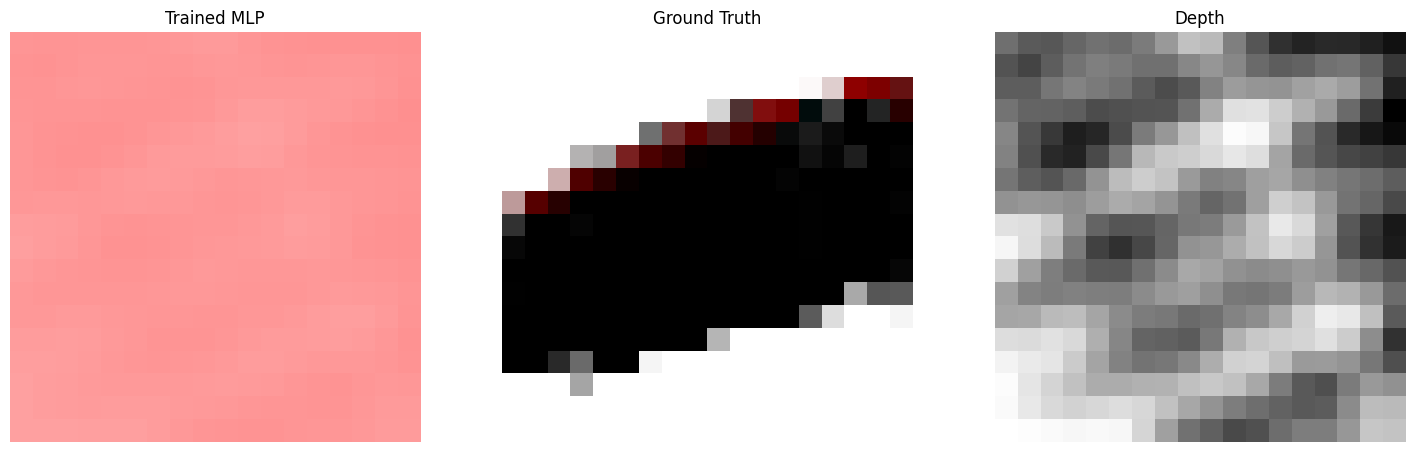

11
12
13
14
15
16
17
18
19
20
Step 20: loss = 0.18515


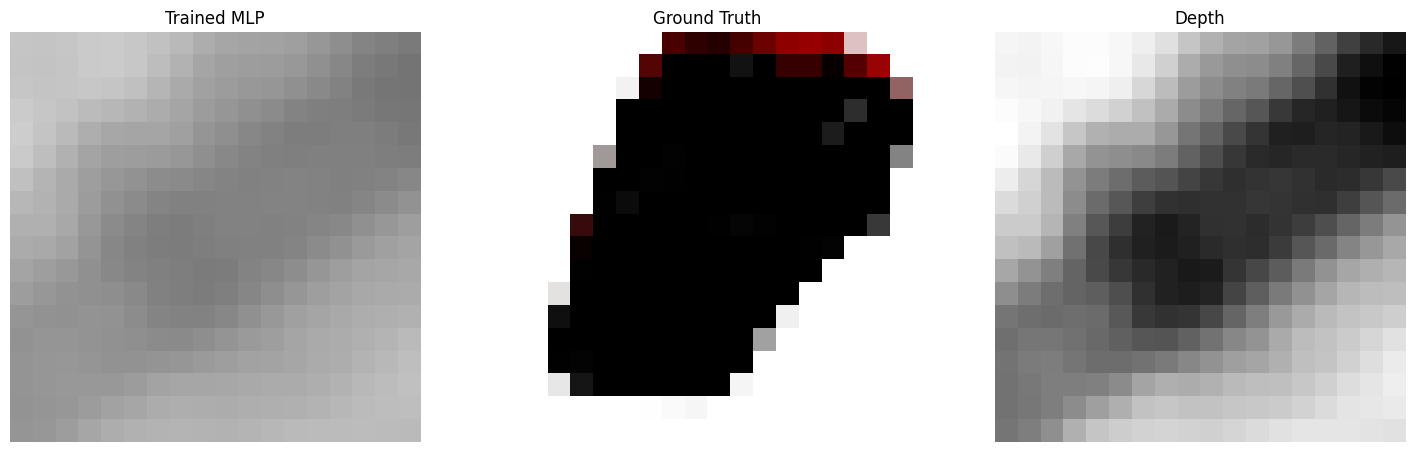

21
22
23
24
25
26
27
28
29
30
Step 30: loss = 0.17773


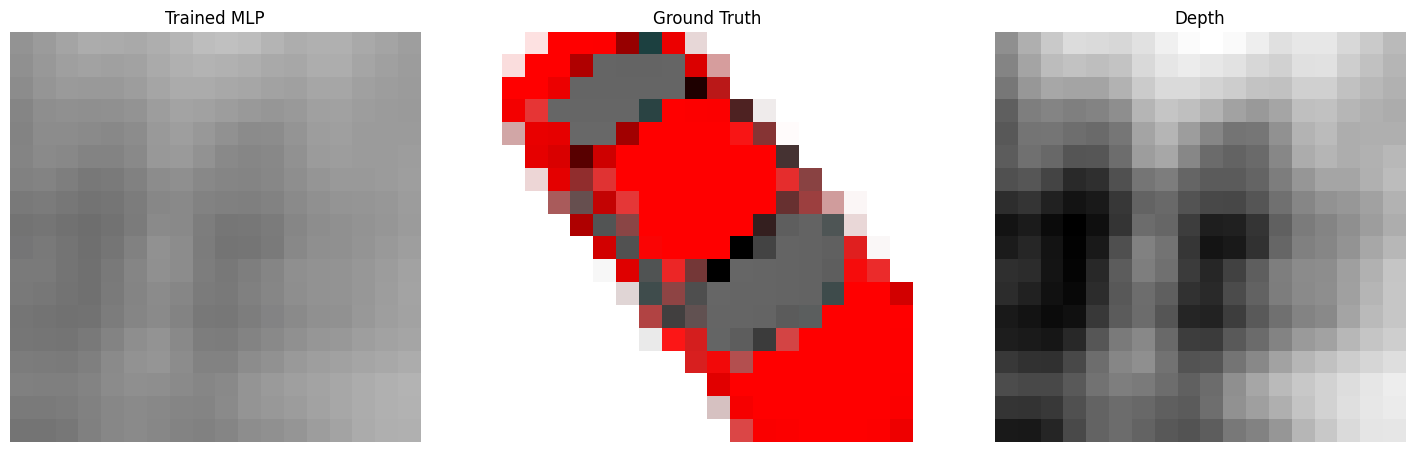

31


In [6]:
######## TODO
# Test dataset
sl = 18
dataset = SRNsCars(f'{root_dir}',max_num_instances=1, img_sidelength=sl)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4)

# Configurations
optim = torch.optim.Adam(lr=1e-3, params=rf_and_renderer.parameters())

try:
    _ = fit(net,
        rf_and_renderer, 
        iter(data_loader), 
        loss_fn=mse_loss, 
        resolution=(sl, sl, 3), 
        plotting_function=plot_output_ground_truth, 
        optimizer=optim, 
        total_steps=500,
        steps_til_summary=10
        )
except Exception:
    print(traceback.format_exc())


In [ ]:
tt = torch.rand([2,3,4])
tt1 = tt.reshape(6,4)
tt2 = tt1.reshape(2,3,4)

In [ ]:
print(tt)
print(tt2)

tensor([[[0.7538, 0.6983, 0.6615, 0.8310],
         [0.6602, 0.3708, 0.9796, 0.7013],
         [0.3108, 0.7523, 0.3698, 0.2963]],

        [[0.0172, 0.2041, 0.7535, 0.9572],
         [0.8818, 0.8619, 0.8408, 0.4384],
         [0.3153, 0.7449, 0.8612, 0.1814]]])
tensor([[[0.7538, 0.6983, 0.6615, 0.8310],
         [0.6602, 0.3708, 0.9796, 0.7013],
         [0.3108, 0.7523, 0.3698, 0.2963]],

        [[0.0172, 0.2041, 0.7535, 0.9572],
         [0.8818, 0.8619, 0.8408, 0.4384],
         [0.3153, 0.7449, 0.8612, 0.1814]]])
